# XGBoost - Heart Disease (Classification)

[ch6-xgboost-hyperparameters.ipynb](https://github.com/kyopark2014/ML-Algorithms/blob/main/xgboost/src/ch6-xgboost-hyperparameters.ipynb)

In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import time

In [4]:
import xgboost as xgb
xgb.set_config(verbosity=0)

In [5]:
import pandas as pd
#df = pd.read_csv('heart_disease.csv')
df = pd.read_csv('https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter06/heart_disease.csv')

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Shuffle

In [6]:
from sklearn.utils import shuffle
df = shuffle(df, random_state=2)

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
99,53,1,2,130,246,1,0,173,0,0.0,2,3,2,1
296,63,0,0,124,197,0,1,136,1,0.0,1,0,2,0
89,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
30,41,0,1,105,198,0,1,168,0,0.0,2,1,2,1
234,70,1,0,130,322,0,0,109,0,2.4,1,3,2,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 99 to 168
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.5 KB


In [8]:
df.isnull().sum().sum()

0

In [9]:
df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

## Define Feature and Target

In [10]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## Classification Model Selection

In [77]:
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=5)

def cross_validation(model):
    start = time.time()
    
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfold)
    # scores = cross_val_score(model, X, y, scoring='recall', cv=kfold)
    
    print('Cross Validation:')
    print('Elased time: %0.2fs' % (time.time()-start))
    print('Accuracy:', np.round(scores, 2))
    print('Avg. Accuracy: %0.2f' % (scores.mean()))

In [78]:
cross_validation(XGBClassifier(booster='gbtree'))  # default

Cross Validation:
Elased time: 41.95s
Accuracy: [0.89 0.8  0.79 0.77 0.77]
Avg. Accuracy: 0.80


In [14]:
cross_validation(XGBClassifier(booster='gblinear'))


Elased time: 1.04s
Accuracy: [0.54 0.54 0.54 0.45 0.55]
Avg. Accuracy: 0.52


In [15]:
cross_validation(XGBClassifier(booster='dart', one_drop=1))


Elased time: 2.56s
Accuracy: [0.89 0.82 0.75 0.8  0.77]
Avg. Accuracy: 0.81


In [16]:
from sklearn.ensemble import RandomForestClassifier

cross_validation(RandomForestClassifier())


Elased time: 0.56s
Accuracy: [0.87 0.84 0.79 0.75 0.82]
Avg. Accuracy: 0.81


## HPO

### Default

In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split train/test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# define model
model = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

# default model accuacry 
def getAccuracy(model):
    start = time.time()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    default_score = accuracy_score(y_pred, y_test)

    print('Elapsed time: %0.2fs' % (time.time()-start))    
    print('default score: %0.2f' % (default_score))

getAccuracy(model)

default score: 0.84
Elased time: 0.26s


## HPO: Randomized Search

In [19]:
from sklearn.model_selection import RandomizedSearchCV

def randomized_search(params, runs=20): 
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    rand_clf = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=runs, n_jobs=-1, random_state=2, scoring='accuracy')
    
    rand_clf.fit(X_train, y_train)    
    
    best_model = rand_clf.best_estimator_    
    
    best_params = rand_clf.best_params_
    print("best parameter:", best_params)
    
    best_score = rand_clf.best_score_
    print("best score: {:.3f}".format(best_score))
    
    return best_model

In [ ]:
import time
start = time.time()

best_model = randomized_search(
    params={
        'n_estimators':[50, 100, 200],
        'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'max_depth':[1, 2, 3, 5, 6, 8],
        'gamma':[0, 0.01, 0.1, 0.5, 1, 2],
        'min_child_weight':[1, 2, 3, 4, 5],
        'subsample':[0.5, 0.7, 0.8, 0.9, 1],
        'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1],  
        }, 
    runs=20)

print('\nElapsed time: %0.2fs' % (time.time()-start))

best parameter: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 1, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 0.9}
best score: 0.837

Elased time: 1368.75s


In [79]:
best_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.4,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 1,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 50,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 2,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0}

## Evaluation

In [80]:
model = best_model

def model_estimation(model):    
    y_pred = model.predict(X_test)

    from sklearn.metrics import confusion_matrix
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

    from sklearn.metrics import classification_report
    print('\nClassification Report:')
    print(classification_report(y_true=y_test, y_pred = y_pred))

    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
    print('Accuracy Score: %0.2f' % (accuracy_score(y_test,y_pred)))
    print('Precision Score: %0.2f' % (precision_score(y_test,y_pred)))
    print('Recall Score: %0.2f' % (recall_score(y_test,y_pred)))
    print('F1 Score: %0.2f' % (f1_score(y_test,y_pred)))

cross_validation(model)   
model_estimation(model)    

Cross Validation:
Elased time: 2.68s
Accuracy: [0.92 0.84 0.77 0.8  0.82]
Avg. Accuracy: 0.83

Confusion Matrix:
[[28  5]
 [ 6 37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        33
           1       0.88      0.86      0.87        43

    accuracy                           0.86        76
   macro avg       0.85      0.85      0.85        76
weighted avg       0.86      0.86      0.86        76

Accuracy Score: 0.86
Precision Score: 0.88
Recall Score: 0.86
F1 Score: 0.87


## Feature Importances

Feature Importances:
[0.0129246  0.04358865 0.16563965 0.02127193 0.01516643 0.
 0.         0.0222752  0.08970502 0.06859989 0.04880068 0.12616937
 0.38585854]
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


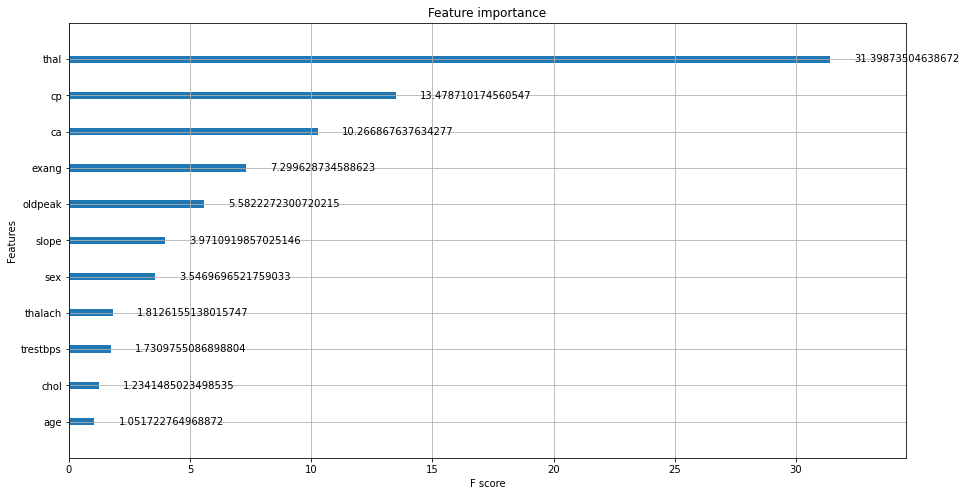

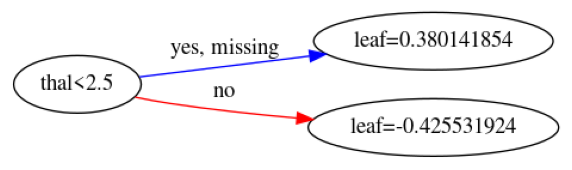

In [82]:
print('Feature Importances:')
print(model.feature_importances_)

import xgboost as xgb

feature_data = xgb.DMatrix(X_test)
model.get_booster().feature_names = feature_data.feature_names
model.get_booster().feature_types = feature_data.feature_types

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(model, ax=ax, importance_type='gain')

!pip install graphviz

xgb.plot_tree(model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

### HPO: GridSearchCV

In [59]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [60]:
import time

def grid_search(params): 
    start = time.time()

    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        random_state=2, verbosity=0, use_label_encoder=False)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
    
    grid.fit(X_train, y_train)
    
    # eval_set = [(X_test, y_test)]
    # eval_metric='error'
    # rand_clf.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set)

    best_params = grid.best_params_
    print("Best parameter:", best_params)
    
    best_score = grid.best_score_
    print('Best accuracy:', np.round(best_score, 3))
    
    print('Elased time: %0.2fs' % (time.time()-start))

In [61]:
import time
grid_start = time.time()

In [62]:
grid_search(
    params={'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5], 
                    'max_depth':[1], 
                    'n_estimators':[50]})

Best parameter: {'learning_rate': 0.4, 'max_depth': 1, 'n_estimators': 50}
Best accuracy: 0.828
Elased time: 81.44s


In [63]:
grid_end = time.time()
elapsed = grid_end - grid_start
print('\nElased time: ' + str(elapsed) + ' s')


Elased time: 82.31653475761414 s
